# Week 09 — Time-Series Fundamentals: Seasonality & Autocorrelation

This notebook covers the classical statistical time-series toolkit:
- Decomposition (trend / seasonal / residual)
- ACF and PACF — reading lag correlations
- Stationarity and the ADF test
- ARIMA / SARIMA model identification, fitting, and diagnostics
- Walk-forward cross-validation for forecast evaluation

> **Dependency**: this notebook requires `statsmodels`. Install with `pip install statsmodels`.

---
### 📚 Theory & References

- [📖 **Week 09 Theory** — Time Series](theory.md)
- [Week 03 — Linear regression (AR models extend this)](../../02_fundamentals/week03_linear_models/theory.md#3-linear-regression)
- [Week 06 — Time-series cross-validation](../../02_fundamentals/week06_regularization/theory.md#7-time-series-cross-validation)
- [Week 07–08 — Likelihood & residual diagnostics](../week07_likelihood/theory.md#4-maximum-likelihood-estimation-mle)

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

%matplotlib inline
np.random.seed(42)
print('Libraries imported!')

Libraries imported!


In [ ]:
import os, pickle

CACHE_DIR = 'cache_week09_ts'
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f'{key}.pkl'), 'wb') as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f'{key}.pkl')
    if os.path.exists(path):
        with open(path, 'rb') as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] loaded '{key}'")
        return result
    print(f"[cache] computing '{key}'...")
    result = compute_fn()
    save_result(key, result)
    return result

print('Cache utilities ready:', CACHE_DIR)

Cache utilities ready: cache_week07_ts


## 1. Load Data — AirPassengers

Classic monthly international airline passenger counts, 1949–1960.  
Strong **multiplicative** seasonality (amplitude grows with level) + upward trend.

Date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Freq: MS, Name: Passengers, dtype: int64

Series length: 144 monthly observations


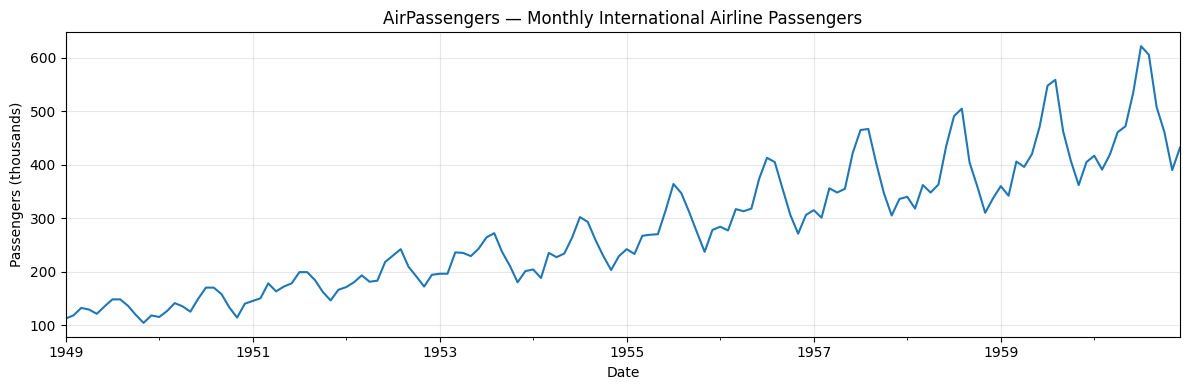

In [4]:
air = sm.datasets.get_rdataset('AirPassengers').data.copy()
# 'time' column may be float-encoded — create a proper DatetimeIndex
air.index = pd.date_range(start='1949-01', periods=len(air), freq='MS')
series = air['value'].rename('Passengers')
series.index.name = 'Date'

print(series.head())
print(f'\nSeries length: {len(series)} monthly observations')

plt.figure(figsize=(12, 4))
series.plot()
plt.title('AirPassengers — Monthly International Airline Passengers')
plt.ylabel('Passengers (thousands)'); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

## 2. Time-Series Decomposition

Two models:
- **Additive**: $Y_t = T_t + S_t + R_t$ — seasonal amplitude is constant.
- **Multiplicative**: $Y_t = T_t \times S_t \times R_t$ — seasonal amplitude grows with trend.  
  Equivalent to additive on $\log(Y_t)$.

STL (Seasonal-Trend decomposition using LOESS) is more robust to outliers.

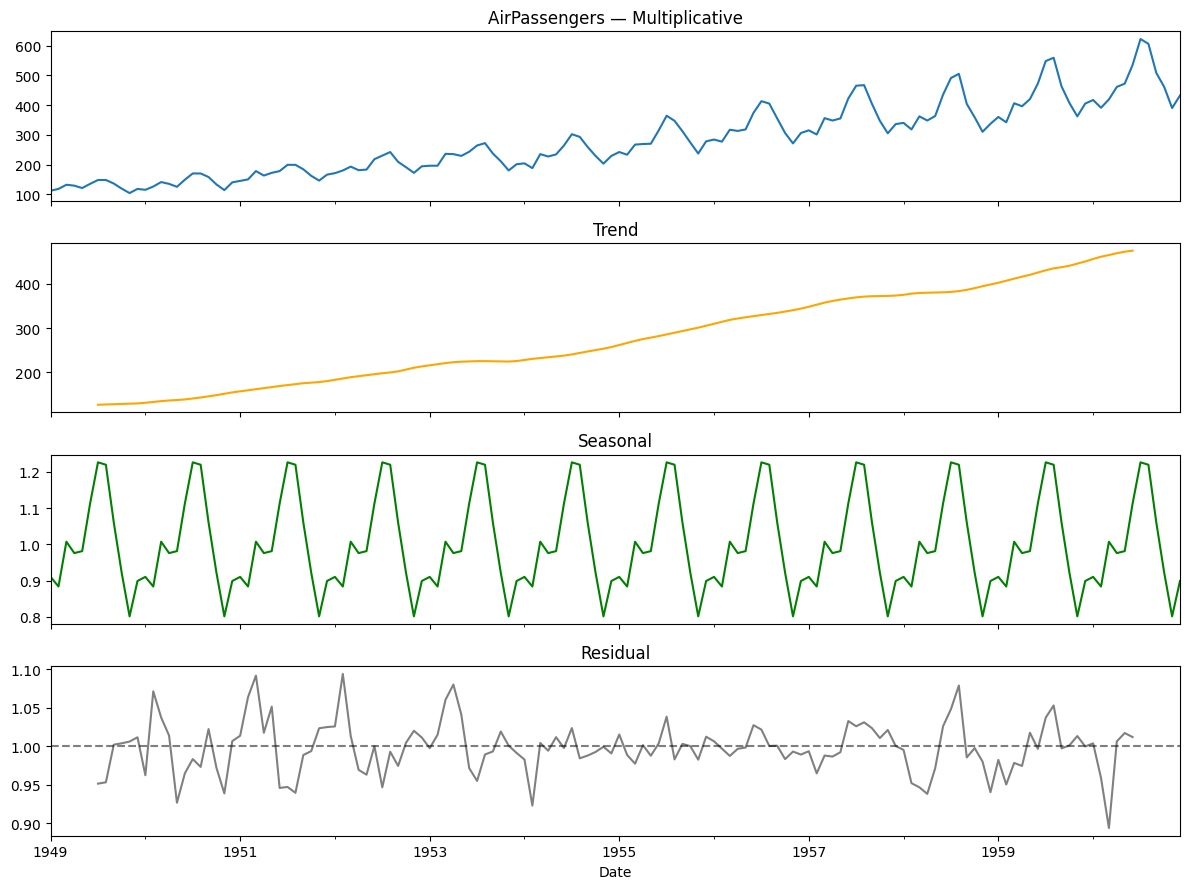

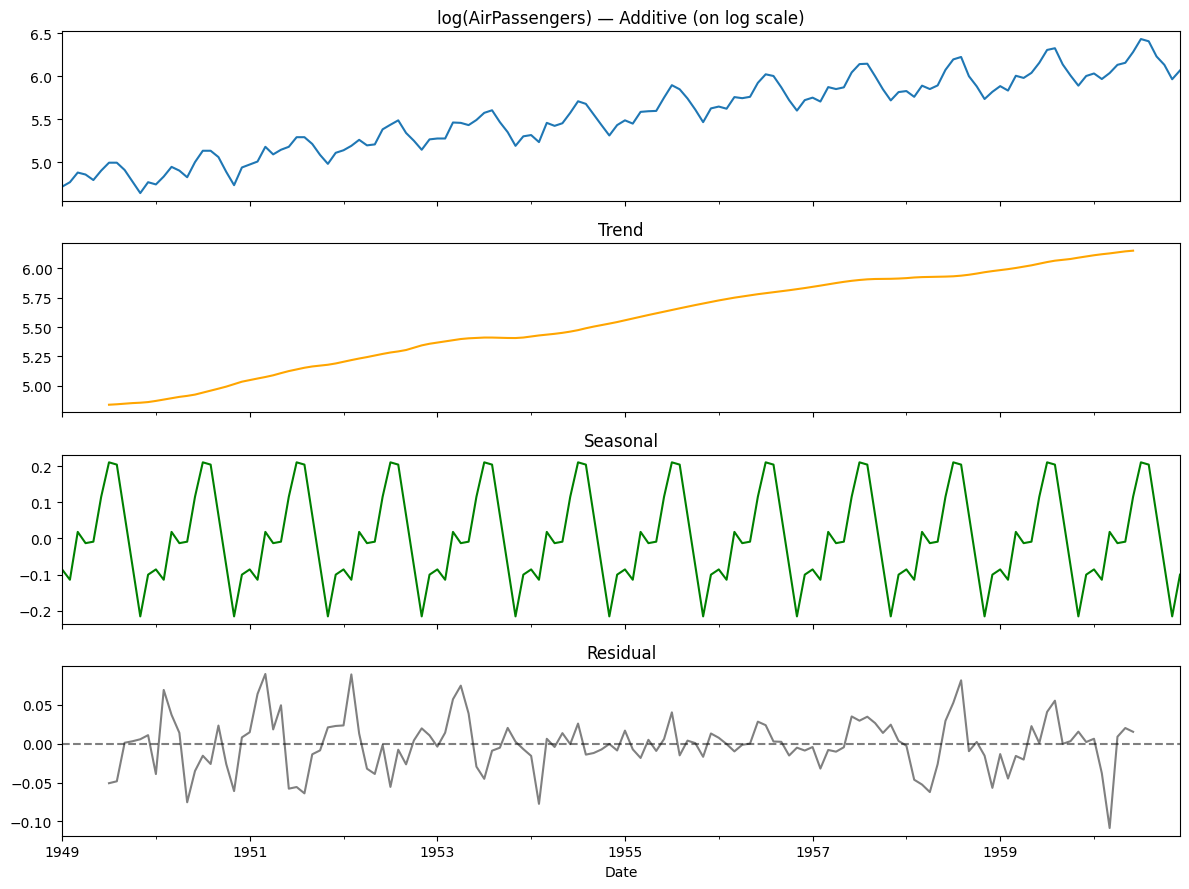

In [5]:
def plot_decomposition(series, model='multiplicative', title=''):
    result = seasonal_decompose(series, model=model, period=12)
    fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
    result.observed.plot(ax=axes[0], title=title or f'Decomposition ({model})')
    result.trend.plot(ax=axes[1], title='Trend', color='orange')
    result.seasonal.plot(ax=axes[2], title='Seasonal', color='green')
    result.resid.plot(ax=axes[3], title='Residual', color='gray')
    axes[3].axhline(1 if model == 'multiplicative' else 0, color='black', linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()
    return result

decomp_mult = plot_decomposition(series, model='multiplicative', title='AirPassengers — Multiplicative')
decomp_add  = plot_decomposition(np.log(series), model='additive', title='log(AirPassengers) — Additive (on log scale)')

## 3. Autocorrelation Function (ACF) and PACF

**ACF** at lag $k$: $\rho_k = \text{Corr}(Y_t, Y_{t-k})$ — measures total correlation.  
**PACF** at lag $k$: correlation between $Y_t$ and $Y_{t-k}$ after removing effects of intermediate lags.

Pattern recognition:
- **AR(p)**: PACF cuts off at lag p; ACF decays gradually.
- **MA(q)**: ACF cuts off at lag q; PACF decays gradually.
- **Seasonal spikes**: ACF/PACF show spikes at multiples of the seasonal period.

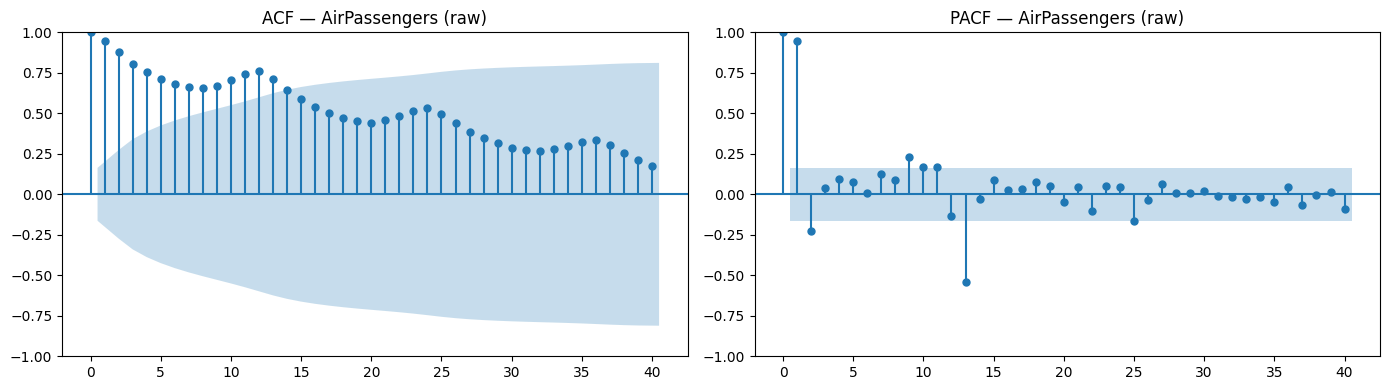

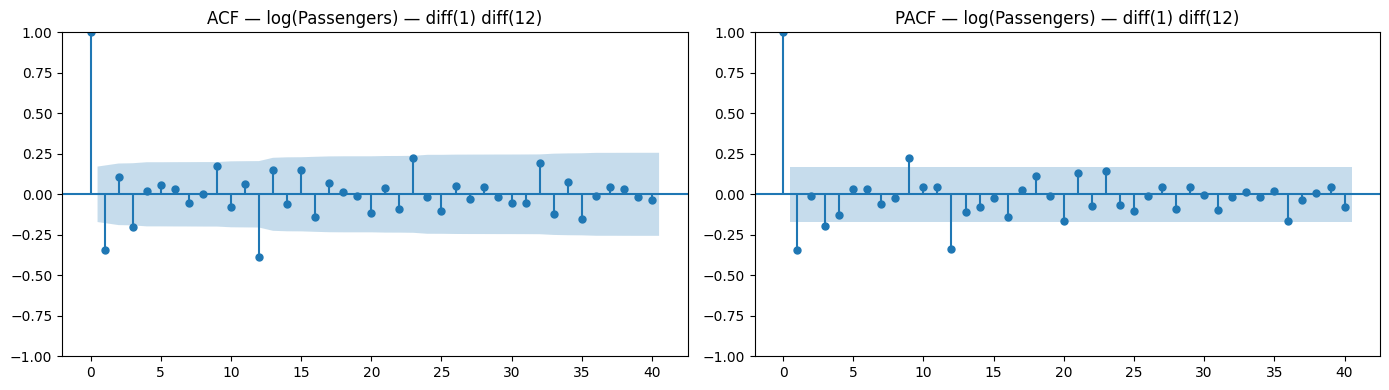

In [6]:
def plot_acf_pacf(series, lags=40, title=''):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(series, lags=lags, ax=axes[0], title=f'ACF — {title}')
    plot_pacf(series, lags=lags, ax=axes[1], title=f'PACF — {title}', method='ywm')
    plt.tight_layout(); plt.show()


# Raw AirPassengers — strong seasonal ACF spikes
plot_acf_pacf(series, title='AirPassengers (raw)')

# After log + first-order difference + seasonal difference
log_series = np.log(series)
log_diff1 = log_series.diff(1).dropna()
log_diff1_12 = log_diff1.diff(12).dropna()
plot_acf_pacf(log_diff1_12, title='log(Passengers) — diff(1) diff(12)')

## 4. Stationarity — ADF Test & Differencing

In [7]:
def adf_test(series, name='series'):
    """Augmented Dickey-Fuller test. H0: series has a unit root (non-stationary)."""
    result = adfuller(series.dropna(), autolag='AIC')
    verdict = 'STATIONARY (reject H0)' if result[1] < 0.05 else 'NON-STATIONARY (fail to reject H0)'
    print(f'{name:<45}  ADF={result[0]:7.3f}  p={result[1]:.4f}  → {verdict}')
    return result


adf_test(series,          'Raw Passengers')
adf_test(log_series,      'log(Passengers)')
adf_test(log_diff1,       'log diff(1)')
adf_test(log_diff1_12,    'log diff(1) diff(12)')

Raw Passengers                                 ADF=  0.815  p=0.9919  → NON-STATIONARY (fail to reject H0)
log(Passengers)                                ADF= -1.717  p=0.4224  → NON-STATIONARY (fail to reject H0)
log diff(1)                                    ADF= -2.717  p=0.0711  → NON-STATIONARY (fail to reject H0)
log diff(1) diff(12)                           ADF= -4.443  p=0.0002  → STATIONARY (reject H0)


(np.float64(-4.4433249418311185),
 np.float64(0.00024859123113840924),
 12,
 118,
 {'1%': np.float64(-3.4870216863700767),
  '5%': np.float64(-2.8863625166643136),
  '10%': np.float64(-2.580009026141913)},
 np.float64(-415.5597525461335))

## 5. ACF/PACF on Synthetic AR / MA Processes

Generate known processes to build intuition for reading ACF/PACF.

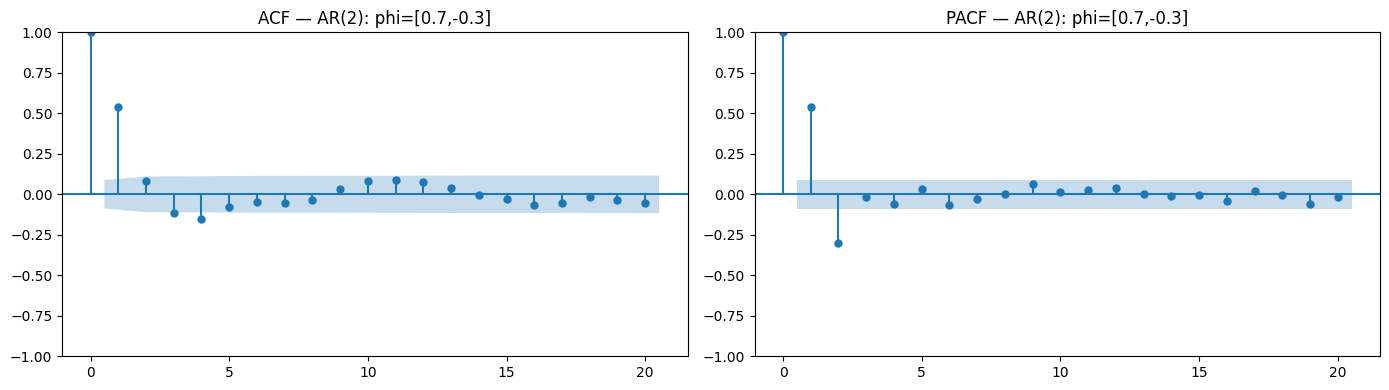

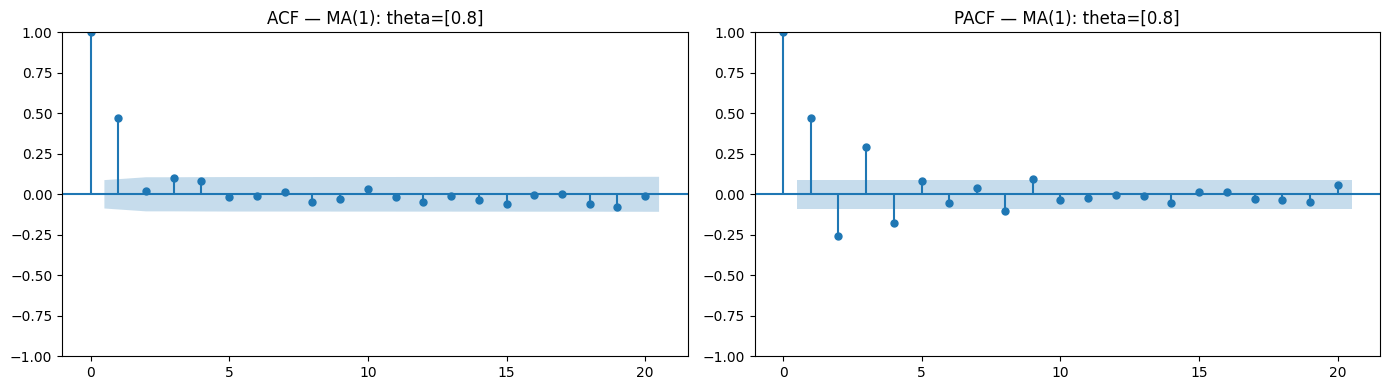

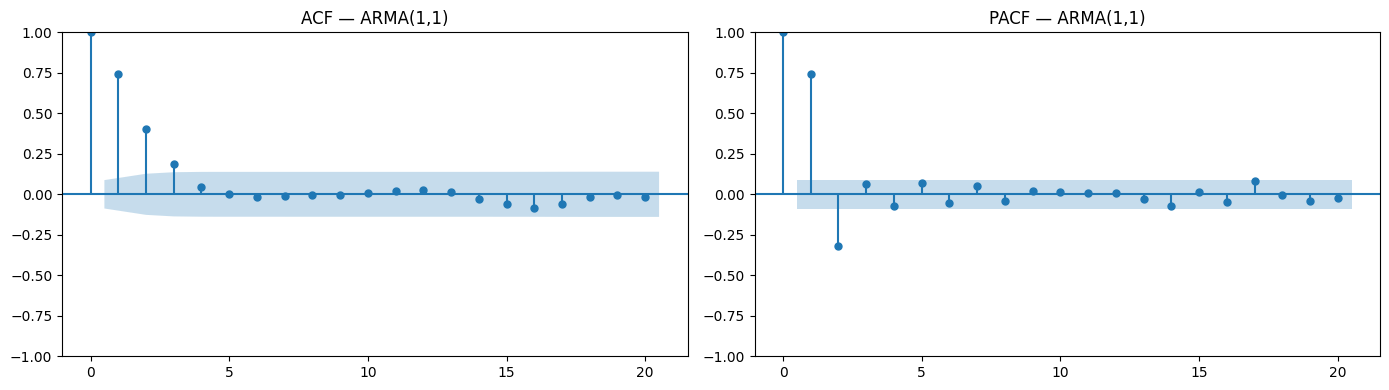

In [8]:
from statsmodels.tsa.arima_process import arma_generate_sample

n = 500
processes = {
    'AR(2): phi=[0.7,-0.3]': dict(ar=[1, -0.7,  0.3],  ma=[1]),
    'MA(1): theta=[0.8]':    dict(ar=[1],               ma=[1,  0.8]),
    'ARMA(1,1)':             dict(ar=[1, -0.6],          ma=[1,  0.4]),
}

for title, params in processes.items():
    sample = arma_generate_sample(**params, nsample=n, burnin=200)
    plot_acf_pacf(pd.Series(sample), lags=20, title=title)

## 6. ARIMA Model — Fitting and Diagnostics

[cache] computing 'arima_111_log_air'...
                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 124.313
Date:                Fri, 20 Feb 2026   AIC                           -242.626
Time:                        10:30:48   BIC                           -233.738
Sample:                    01-01-1949   HQIC                          -239.014
                         - 12-01-1960                                         
Covariance Type:                  opg                                         


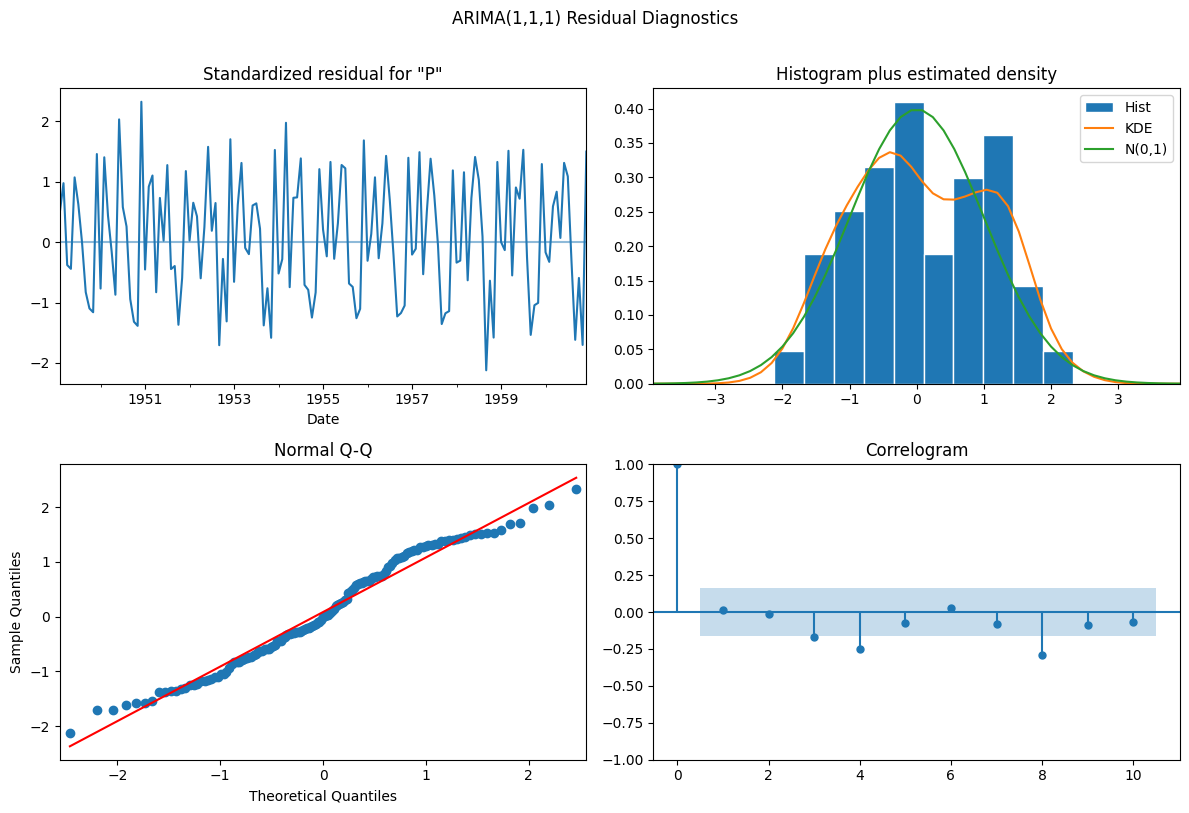

In [9]:
def fit_arima(series, order=(1, 1, 1)):
    model = ARIMA(series, order=order, trend='n')
    return model.fit()


# Fit ARIMA(1,1,1) on log-transformed AirPassengers (ignoring seasonality for now)
def _fit_simple_arima():
    return fit_arima(log_series, order=(1, 1, 1))

arima_fit = cached('arima_111_log_air', _fit_simple_arima)
print(arima_fit.summary().tables[0])

# Residual diagnostics
arima_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle('ARIMA(1,1,1) Residual Diagnostics', y=1.01)
plt.tight_layout(); plt.show()

## 7. SARIMA — Seasonal ARIMA

[cache] computing 'sarima_air_1111_1112'...
                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 218.517
Date:                            Fri, 20 Feb 2026   AIC                           -427.035
Time:                                    10:30:51   BIC                           -413.224
Sample:                                01-01-1949   HQIC                          -421.428
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         


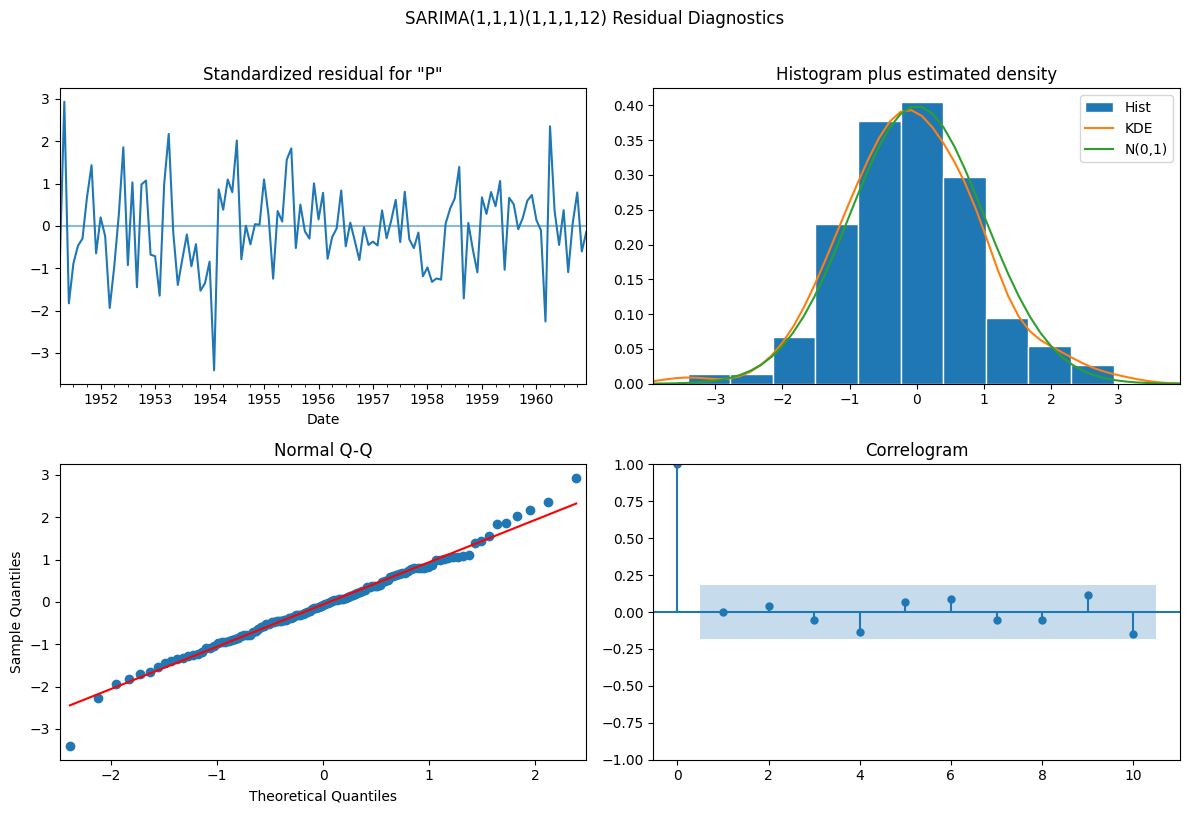

In [10]:
def fit_sarima(series, order, seasonal_order):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    return model.fit(disp=False)


def _fit_sarima_air():
    # SARIMA(1,1,1)(1,1,1,12) on log(AirPassengers) — standard benchmark
    return fit_sarima(log_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

sarima_fit = cached('sarima_air_1111_1112', _fit_sarima_air)
print(sarima_fit.summary().tables[0])

# Residuals
sarima_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle('SARIMA(1,1,1)(1,1,1,12) Residual Diagnostics', y=1.01)
plt.tight_layout(); plt.show()

## 8. Walk-Forward Cross-Validation & Forecast Evaluation

[cache] loaded 'sarima_wf_cv_12'
Walk-Forward CV (last 12 months)  RMSE=18.70  MAPE=2.78%


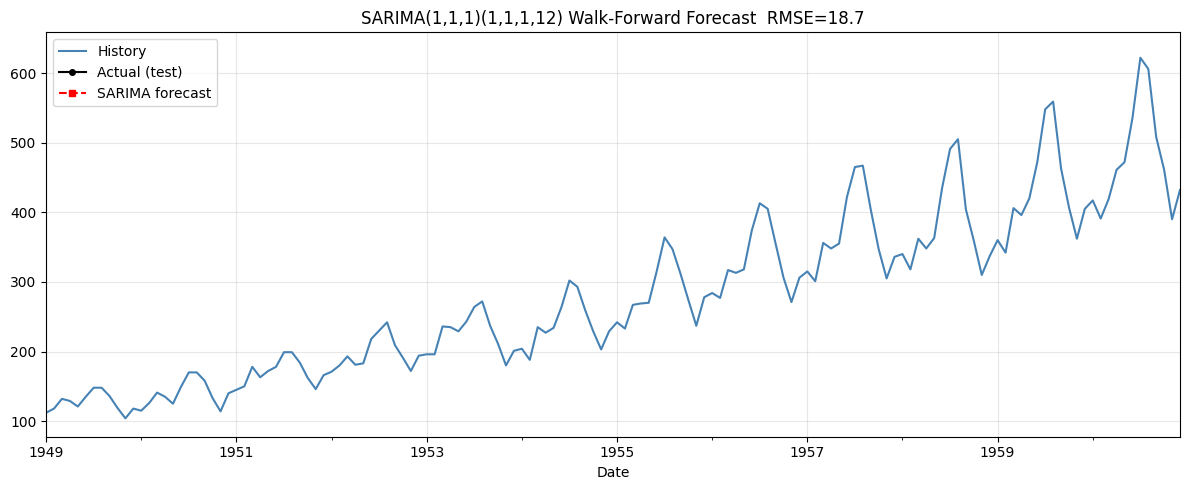

[415.79854359 393.10243306 456.10996465 420.1550171  465.10682139
 544.20064704 613.98816683 632.10931277 506.73814985 447.6212836
 399.00853428 434.33837255]


In [ ]:
def walk_forward_cv(series, order, seasonal_order, n_test=12, step=1):
    """Rolling-origin walk-forward CV: refit model at each origin and forecast 1 step ahead.
    Returns actual and predicted values for the test window.
    """
    history = series.iloc[:-n_test].copy()
    test    = series.iloc[-n_test:]
    preds = []
    for i in range(n_test):
        model = SARIMAX(history, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        fc = res.forecast(steps=step)
        preds.append(float(fc.iloc[0]))
        history = pd.concat([history, test.iloc[[i]]])
    return np.array(preds), test.values


def _run_wf_cv():
    return walk_forward_cv(log_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

preds_log, actuals_log = cached('sarima_wf_cv_12', _run_wf_cv)
preds = np.exp(preds_log)
actuals = np.exp(actuals_log)

rmse = np.sqrt(mean_squared_error(actuals, preds))
mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
print(f'Walk-Forward CV (last 12 months)  RMSE={rmse:.2f}  MAPE={mape:.2f}%')

# Plot
plt.figure(figsize=(12, 5))
series.plot(label='History', color='steelblue')
test_idx = series.index[-12:]
plt.plot(test_idx, actuals, 'ko-', label='Actual (test)', markersize=4)
plt.plot(test_idx, preds,   'rs--', label='SARIMA forecast', markersize=4)
plt.title(f'SARIMA(1,1,1)(1,1,1,12) Walk-Forward Forecast  RMSE={rmse:.1f}')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

## Exercises

1. **Decomposition comparison** — compare additive and multiplicative decomposition on AirPassengers; compute residual variance for each and decide which fits better.
2. **ACF/PACF reading** — generate AR(2), MA(1), and ARMA(1,1) processes; annotate which lags are significant and propose model orders.
3. **Stationarity** — verify ADF test p-values before/after differencing. Try the sunspots dataset.
4. **ARIMA fitting** — use the ACF/PACF of `log_diff1_12` to propose (p,d,q); fit and compare AIC/BIC with ARIMA(1,1,1).
5. **SARIMA walk-forward CV** — extend walk-forward CV to forecast h=3 steps ahead; compute RMSE for each horizon and plot.

In [12]:
# EXERCISE 1 — Additive vs Multiplicative decomposition
# Goal: decompose AirPassengers with both models; compute variance of residuals.
# Report which model leaves smaller residual variance.

In [13]:
# EXERCISE 2 — ACF/PACF identification
# Goal: generate AR(2) with phi=[0.7,-0.3]; MA(2) with theta=[0.6,0.3].
# Plot ACF/PACF; annotate the cut-off lags and propose model orders.

In [14]:
# EXERCISE 3 — Sunspots stationarity
# Goal: load sm.datasets.sunspots.load_pandas().data; apply adf_test.
# Difference once if non-stationary; re-test.

In [15]:
# EXERCISE 4 — ARIMA order selection
# Goal: propose an order from log_diff1_12 ACF/PACF; fit ARIMA with that order.
# Compare AIC/BIC with ARIMA(1,1,1). Print both summaries.

In [16]:
# EXERCISE 5 — Multi-horizon walk-forward CV
# Goal: modify walk_forward_cv to accept h as parameter (forecast h steps).
# Run for h in [1, 3, 6, 12]; plot RMSE vs horizon h.
# Expected: RMSE grows with horizon (uncertainty accumulates).